# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
display('before',train.isna().sum(),test.isna().sum())
train.fillna('',inplace=True)
test.fillna('',inplace=True)
display('after',train.isna().sum(),test.isna().sum())

'before'

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

'after'

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [6]:
train['target'].value_counts()

0    3024
1    2305
Name: target, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [7]:
display(train['keyword'].value_counts())
popular_keywords = np.array(train['keyword'].value_counts()[1:11].keys()) # 1ый  - пустая строка

train_popular = train[train['keyword'].isin(popular_keywords)]

                         44
damage                   36
siren                    35
wreckage                 34
fatalities               33
                         ..
rescue                   16
epicentre                10
radiation%20emergency     7
inundation                7
threat                    6
Name: keyword, Length: 222, dtype: int64

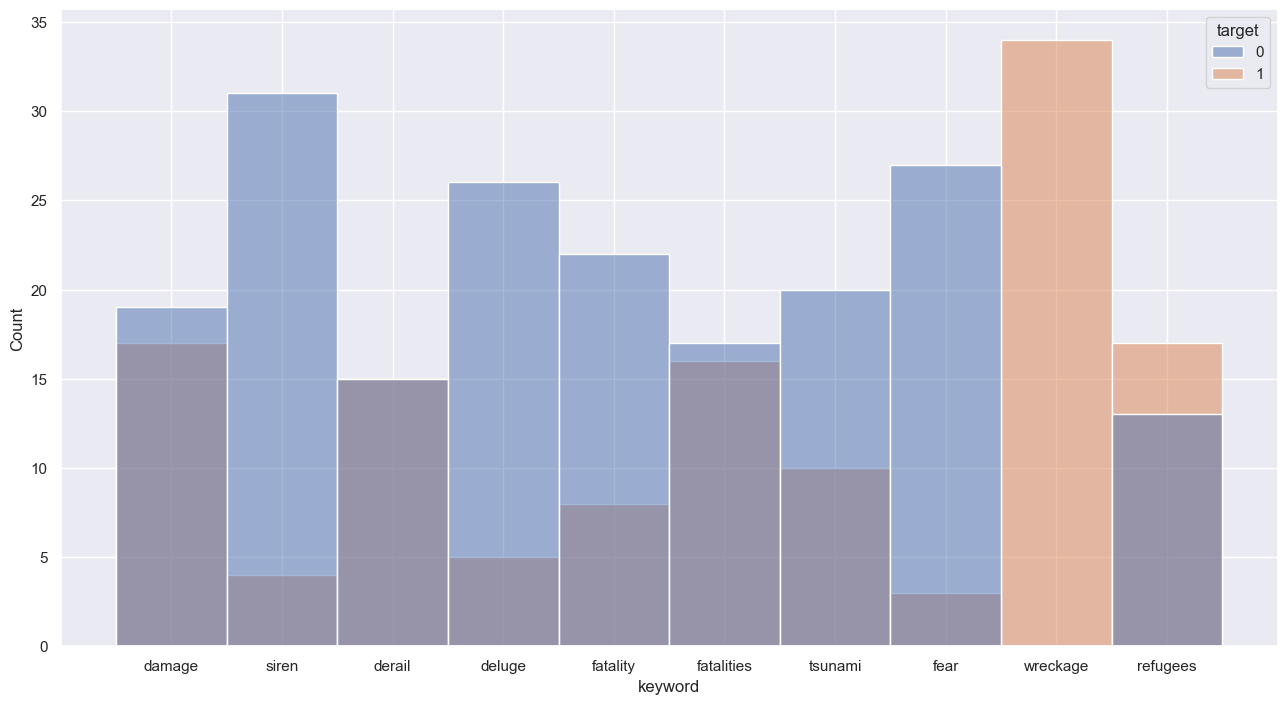

In [9]:
sns.histplot(train_popular,x = 'keyword',hue = 'target')
sns.set(rc={'figure.figsize':(20,8.27)})
plt.show()

**Выводы**: В основном в выборке преобладают объекты нулевого класса, для ключевых слов fatalities, damage, derail распределение близко к равномерному. В siren,deluge,fatality,tsunami,fear преобладает нулевой класс. Слово wreckage встречается только в 1ом классе, 1ый класс также доминирует в слове refugees.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [10]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [11]:
train = train.drop('id',axis = 1)
train['text'] = train[['keyword','location','text']].agg(' '.join,axis = 1)
train_new = train.drop(['keyword','location'],axis = 1)

test['text'] = test[['keyword','location','text']].agg(' '.join,axis = 1)
test_new = test.drop(['id','keyword','location'],axis = 1)

In [12]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()
vector.fit_transform(train_new['text'])
matrix = vector.vocabulary_
print(train_new.shape[0],len(matrix)) # 5329 строк 18455 столбцов

5329 18455


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [18]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(symbol.isdigit() for symbol in s)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(symbol in punctuation for symbol in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == "@"

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', sum(list(map(contains_digit,vocabulary.keys())))
          )
    print('With punctuation:', sum(list(map(contains_punctuation,vocabulary.keys())))
          )
    print('Hashtags:        ', sum(list(map(is_hashtag,vocabulary.keys())))
          )
    print('Mentions:        ', sum(list(map(is_mention,vocabulary.keys())))
          )




In [19]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)


With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [20]:
investigate_vocabulary(matrix)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [21]:
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()

new_vector = CountVectorizer(tokenizer = tw.tokenize)
new_vector.fit_transform(train_new['text'])
new_matrix = new_vector.vocabulary_
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

C:\Users\meto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [22]:
print(train_new.shape[0],len(new_matrix)) # 5329 строк 19670 столбцов

5329 19670


In [23]:
investigate_vocabulary(new_matrix)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** по сравнению с обычным методом CountVectorizer добавление TweetTokenizer сохраняет слова с хэштегами, упоминаниями, ссылками. Следовательно растет показатель хэштегов\упоминаний\слов с пунктуацией 

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [24]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all((65 <= ord(symbol) <= 90 or 97 <= ord(symbol)<= 122) for symbol in s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    flag = False
    for i in s:
        if i in ['(',')','{','}','[',']']:
            flag = True
            break
    return flag and all(symbol in punctuation for symbol in s)
def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#' and contains_only_latin_letters(s[1:])  
def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    s = s.lower()
    tweet = TweetTokenizer()
    temp = tweet.tokenize(s)
    text_wt_trash = []
    for i in temp:
        if contains_only_latin_letters(i) or is_emoji(i) or is_hashtag(i):
            if i not in stopwords.words('english'):
                text_wt_trash.append(i)
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in text_wt_trash]
    return words

In [25]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [26]:
arr = np.array(train_new['text'].head(10))
for i in arr:
    print(custom_tokenizer(i))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [27]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
new_matrix_tr = vectorizer.fit_transform(train_new['text'])
new_matrix_test = vectorizer.transform(test_new['text'])

In [28]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       0
With punctuation: 1338
Hashtags:         1323
Mentions:         0


In [29]:
custom_vec_data_tr = pd.DataFrame(new_matrix_tr.toarray(), columns=vectorizer.get_feature_names_out())
custom_vec_data_test = pd.DataFrame(new_matrix_test.toarray(), columns=vectorizer.get_feature_names_out())

2. Обучите LogisticRegression на полученных признаках.


In [30]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(custom_vec_data_tr,train_new['target'])

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [31]:
from sklearn.metrics import f1_score

f1_score(test_new['target'],model.predict(custom_vec_data_test))

0.752017213555675

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tf = TfidfVectorizer(tokenizer=custom_tokenizer)
new_matrix_tr_tf = vectorizer_tf.fit_transform(train_new['text'])
new_matrix_test_tf = vectorizer_tf.transform(test_new['text'])
display(new_matrix_tr_tf)

custom_vec_data_tf_tr = pd.DataFrame(new_matrix_tr_tf.toarray(), columns=vectorizer_tf.get_feature_names_out())
custom_vec_data_tf_test = pd.DataFrame(new_matrix_test_tf.toarray(), columns=vectorizer_tf.get_feature_names_out())

model_tf = LogisticRegression()
model_tf.fit(custom_vec_data_tf_tr,train_new['target'])

f1_score(test_new['target'],model_tf.predict(custom_vec_data_tf_test))

<5329x10486 sparse matrix of type '<class 'numpy.float64'>'
	with 51133 stored elements in Compressed Sparse Row format>

0.7412353923205343

1. **Ответ:** качество уменьшилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [35]:
vectorizer_tf_df = TfidfVectorizer(max_df=9/10,tokenizer=custom_tokenizer)
new_matrix_tr_tf_df = vectorizer_tf_df.fit_transform(train_new['text'])
new_matrix_test_tf_df = vectorizer_tf_df.transform(test_new['text'])
display(new_matrix_tr_tf_df)
custom_vec_data_tf_tr_df = pd.DataFrame(new_matrix_tr_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())
custom_vec_data_tf_test_df = pd.DataFrame(new_matrix_test_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())

model_tf_df = LogisticRegression()
model_tf_df.fit(custom_vec_data_tf_tr_df,train_new['target'])

f1_score(test_new['target'],model_tf_df.predict(custom_vec_data_tf_test_df))

C:\Users\meto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x10486 sparse matrix of type '<class 'numpy.float64'>'
	with 51133 stored elements in Compressed Sparse Row format>

0.7412353923205343

In [37]:
display(custom_vec_data_tf_tr_df.shape,custom_vec_data_tf_tr.shape)


(5329, 10486)

(5329, 10486)

2. **Ответ:** не изменилось количество слов

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [38]:
vectorizer_tf_df = TfidfVectorizer(min_df=0.001,max_df=9/10,tokenizer=custom_tokenizer)
new_matrix_tr_tf_df = vectorizer_tf_df.fit_transform(train_new['text'])
new_matrix_test_tf_df = vectorizer_tf_df.transform(test_new['text'])
display(new_matrix_tr_tf_df)
custom_vec_data_tf_tr_df = pd.DataFrame(new_matrix_tr_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())
custom_vec_data_tf_test_df = pd.DataFrame(new_matrix_test_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())

model_tf_df = LogisticRegression()
model_tf_df.fit(custom_vec_data_tf_tr_df,train_new['target'])

f1_score(test_new['target'],model_tf_df.predict(custom_vec_data_tf_test_df))

C:\Users\meto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x1743 sparse matrix of type '<class 'numpy.float64'>'
	with 37234 stored elements in Compressed Sparse Row format>

0.743139407244786

3. **Ответ:** размерность уменьшилась до 1743, качество возросло

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [39]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_hash = HashingVectorizer(n_features=5000,tokenizer=custom_tokenizer)
new_matrix_hash_tr = vectorizer_hash.fit_transform(train_new['text'])
new_matrix_hash_test = vectorizer_hash.transform(test_new['text'])
display(new_matrix_hash_tr)
new_matrix_hash_tr = new_matrix_hash_tr.toarray()
new_matrix_hash_test = new_matrix_hash_test.toarray()

model_hash = LogisticRegression()
model_hash.fit(new_matrix_hash_tr,train_new['target'])



print('F1 score:',f1_score(test_new['target'],model_hash.predict(new_matrix_hash_test)))

C:\Users\meto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 51095 stored elements in Compressed Sparse Row format>

F1 score: 0.7190635451505016


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** CountVectorizer 

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [40]:
f1_score(test_new['target'],model.predict(custom_vec_data_test)) #было в 8 задании

0.752017213555675

In [66]:
vectorizer_tf_df = TfidfVectorizer(tokenizer=custom_tokenizer)
new_matrix_tr_tf_df = vectorizer_tf_df.fit_transform(train_new['text'])
new_matrix_test_tf_df = vectorizer_tf_df.transform(test_new['text'])
display(new_matrix_tr_tf_df)
custom_vec_data_tf_tr_df = pd.DataFrame(new_matrix_tr_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())
custom_vec_data_tf_test_df = pd.DataFrame(new_matrix_test_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())

C:\Users\meto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x10486 sparse matrix of type '<class 'numpy.float64'>'
	with 51133 stored elements in Compressed Sparse Row format>

In [67]:
from sklearn.svm import SVC
model_tf_df = SVC(kernel='linear',class_weight='balanced',decision_function_shape='ovo')
model_tf_df.fit(custom_vec_data_tf_tr_df,train_new['target'])

f1_score(test_new['target'],model_tf_df.predict(custom_vec_data_tf_test_df))

0.7573719606828764

Выбрал SVM, потому что он лучше классифицирует, чем логистическая регрессия, т.к. ему не нужно заострять внимание на вероятностях, а просто искать лучшее разбиение

In [69]:
vectorizer_tf_df = TfidfVectorizer(min_df = 0.0005,tokenizer=custom_tokenizer)
new_matrix_tr_tf_df = vectorizer_tf_df.fit_transform(train_new['text'])
new_matrix_test_tf_df = vectorizer_tf_df.transform(test_new['text'])
display(new_matrix_tr_tf_df)
custom_vec_data_tf_tr_df = pd.DataFrame(new_matrix_tr_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())
custom_vec_data_tf_test_df = pd.DataFrame(new_matrix_test_tf_df.toarray(), columns=vectorizer_tf_df.get_feature_names_out())

C:\Users\meto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x3138 sparse matrix of type '<class 'numpy.float64'>'
	with 42396 stored elements in Compressed Sparse Row format>

In [70]:
model_tf_df_n = SVC(kernel='linear',class_weight='balanced',decision_function_shape='ovo')
model_tf_df_n.fit(custom_vec_data_tf_tr_df,train_new['target'])

f1_score(test_new['target'],model_tf_df_n.predict(custom_vec_data_tf_test_df))

0.7574511819116136

Ограничил min_df и SVM вместо 28 минут стал считаться 32сек, а качество возросло